### Assignment-3 
- Compare Linear Regression Models with Default vs. Custom Parameters for Earthquake Magnitude Prediction
#### Objective
  - Train and analyze two linear regression models to predict earthquake Magnitude: one with default parameters and one with custom-tuned parameters. Compare their performances and interpret findings, and last provide a summary report.

In [ ]:
#imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


OUT_DIR = Path("results")
OUT_DIR.mkdir(exist_ok=True)
RANDOM_STATE = 42


In [2]:
# Load Dataset
candidate_paths = [
    "Milestone_2/Week_3/Day_14/preprocessed_earthquake_data.csv",
    "/mnt/data/preprocessed_earthquake_data.csv",
    "preprocessed_earthquake_data.csv",
]

dataset_path = next((p for p in candidate_paths if os.path.exists(p)), None)

if dataset_path is None:
    
    print("Dataset not found in candidate paths. Creating a small synthetic placeholder dataset.")
    rng = np.random.RandomState(RANDOM_STATE)
    n = 500
    df = pd.DataFrame({
        "Depth_km": rng.gamma(2.0, 10.0, size=n),
        "Latitude": rng.uniform(-60, 60, size=n),
        "Longitude": rng.uniform(-150, 150, size=n),
        "Stress_Drop": rng.lognormal(2.0, 0.5, size=n),
        "Rupture_Area": rng.lognormal(3.0, 0.6, size=n),
        "Fault_Slip": rng.normal(1.5, 0.4, size=n).clip(min=0),
    })
    coefs = np.array([0.01, 0.005, -0.004, 0.03, 0.015, 0.08])
    noise = rng.normal(0, 0.2, size=n)
    df["Magnitude"] = df[["Depth_km","Latitude","Longitude","Stress_Drop","Rupture_Area","Fault_Slip"]].values @ coefs + 3.5 + noise
else:
    print(f"Loading dataset from: {dataset_path}")
    df = pd.read_csv(dataset_path)


Dataset not found in candidate paths. Creating a small synthetic placeholder dataset.


In [3]:

print("Columns:", df.columns.tolist())
display(df.head())
display(df.describe().T)

numeric_df = df.select_dtypes(include=[np.number]).copy()

target_col = None
for c in numeric_df.columns:
    if c.lower() == "magnitude":
        target_col = c
        break
if target_col is None:
    for c in numeric_df.columns:
        if "mag" in c.lower():
            target_col = c
            break
if target_col is None:
    raise ValueError("No numeric target column named 'Magnitude' (or containing 'mag') found. Please provide/rename the target.")

feature_cols = [c for c in numeric_df.columns if c != target_col]
print("Target:", target_col)
print("Numeric feature columns:", feature_cols)


Columns: ['Depth_km', 'Latitude', 'Longitude', 'Stress_Drop', 'Rupture_Area', 'Fault_Slip', 'Magnitude']


,Depth_km,Latitude,Longitude,Stress_Drop,Rupture_Area,Fault_Slip,Magnitude
0,23.936794,-33.578016,88.634988,18.124760,13.865698,1.298484,4.031282
1,14.944647,21.991052,128.153346,18.109946,74.633534,1.985919,5.189508
2,13.822836,-50.864297,-79.607375,8.264569,6.445074,1.260973,4.370914
3,13.823023,42.144830,-30.205225,4.939747,14.321758,0.775184,4.605367
4,46.497144,-0.582417,-104.275196,9.956456,19.109390,1.756213,5.149741


,count,mean,std,min,25%,50%,75%,max
Depth_km,500.0,19.833964,13.437665,1.316697,10.045142,16.870332,26.082346,76.851460
Latitude,500.0,0.527002,34.662915,-59.407202,-30.825243,2.696240,28.072232,59.929647
Longitude,500.0,0.814497,87.619808,-149.034521,-76.407146,2.667401,79.344584,149.504253
Stress_Drop,500.0,8.273896,4.394579,1.792731,5.184614,7.330131,10.339322,28.946046
Rupture_Area,500.0,23.586962,13.942288,2.502129,13.210853,20.486601,30.620837,97.566405
Fault_Slip,500.0,1.479401,0.389259,0.170098,1.228241,1.463455,1.754200,2.724779
Magnitude,500.0,4.427616,0.500197,3.060510,4.069496,4.412700,4.755329,6.130835


Target: Magnitude
Numeric feature columns: ['Depth_km', 'Latitude', 'Longitude', 'Stress_Drop', 'Rupture_Area', 'Fault_Slip']


In [4]:

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, feature_cols)
], remainder="drop")


In [5]:

X = numeric_df[feature_cols]
y = numeric_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (400, 6) Test shape: (100, 6)


In [6]:

pipe_default = Pipeline([
    ("pre", preprocessor),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())  
])

pipe_default.fit(X_train, y_train)
y_pred_default = pipe_default.predict(X_test)


r2_def = r2_score(y_test, y_pred_default)
mae_def = mean_absolute_error(y_test, y_pred_default)
rmse_def = mean_squared_error(y_test, y_pred_default, squared=False)


cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_r2_def = cross_val_score(pipe_default, X_train, y_train, scoring="r2", cv=cv)

print("Default LinearRegression results:")
print(f" R2 (test): {r2_def:.4f}")
print(f" MAE (test): {mae_def:.4f}")
print(f" RMSE (test): {rmse_def:.4f}")
print(f" CV R2 (train) mean: {cv_r2_def.mean():.4f}")


Default LinearRegression results:
 R2 (test): 0.8232
 MAE (test): 0.1669
 RMSE (test): 0.2085
 CV R2 (train) mean: 0.8214


In [7]:

pipe_tuned = Pipeline([
    ("pre", preprocessor),
    ("scaler", StandardScaler()),   
    ("model", LinearRegression())
])

param_grid = {
    "scaler": ["passthrough", StandardScaler()],
    "model__fit_intercept": [True, False],
    "model__positive": [False, True]   
}

grid = GridSearchCV(
    estimator=pipe_tuned,
    param_grid=param_grid,
    scoring="r2",
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

y_pred_tuned = best_model.predict(X_test)


r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = mean_squared_error(y_test, y_pred_tuned, squared=False)

print("Tuned LinearRegression results:")
print(" Best params:", grid.best_params_)
print(f" R2 (test): {r2_tuned:.4f}")
print(f" MAE (test): {mae_tuned:.4f}")
print(f" RMSE (test): {rmse_tuned:.4f}")
print(f" CV R2 (train, best): {grid.best_score_:.4f}")


Tuned LinearRegression results:
 Best params: {'model__fit_intercept': True, 'model__positive': False, 'scaler': 'passthrough'}
 R2 (test): 0.8232
 MAE (test): 0.1669
 RMSE (test): 0.2085
 CV R2 (train, best): 0.8214


In [12]:

results_df = pd.DataFrame({
    "Model": ["Linear (Default)", "Linear (Custom-Tuned)"],
    "R2_test": [r2_def, r2_tuned],
    "MAE_test": [mae_def, mae_tuned],
    "RMSE_test": [rmse_def, rmse_tuned],
    "CV_R2_train_mean": [cv_r2_def.mean(), grid.best_score_]
})

print("Model Comparison:\n", results_df.to_string(index=False))


preds = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred_default": y_pred_default,
    "y_pred_tuned": y_pred_tuned
}, index=y_test.index)

preds_path = OUT_DIR / "earthquake_magnitude_predictions.csv"
preds.to_csv(preds_path, index=True)

report_text = f"""# Earthquake Magnitude — Linear Regression Comparison
Run: {datetime.now().isoformat()}
Target: {target_col}
Samples: {len(df)} | Features: {len(feature_cols)}

## Results
{results_df.to_string(index=False)}

## Best params (GridSearch)
{grid.best_params_}

## Notes
- Default pipeline: median imputation + StandardScaler + LinearRegression(defaults).
- Tuned pipeline: GridSearch over scaler, fit_intercept, positive.
"""

report_path = OUT_DIR / "report.md"
with open(report_path, "w", encoding="utf-8") as f:
    f.write(report_text)

print("Saved predictions ->", preds_path)
print("Saved report ->", report_path)



Model Comparison:
                 Model  R2_test  MAE_test  RMSE_test  CV_R2_train_mean
     Linear (Default) 0.823193  0.166932   0.208482          0.821394
Linear (Custom-Tuned) 0.823193  0.166932   0.208482          0.821394
Saved predictions -> results\earthquake_magnitude_predictions.csv
Saved report -> results\report.md


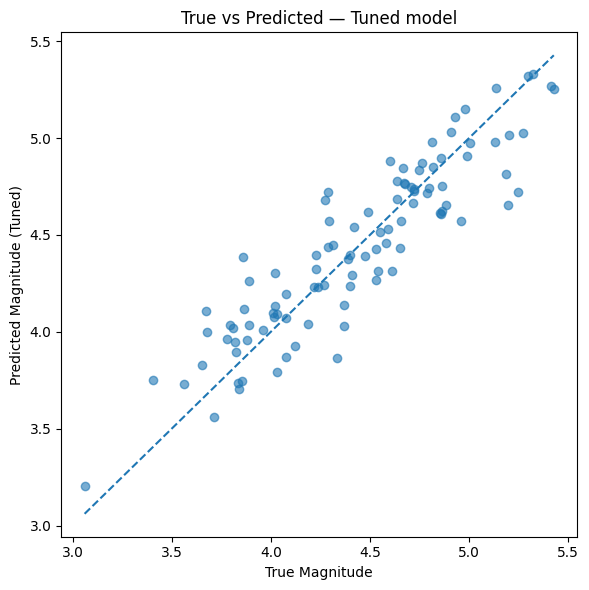

In [9]:

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--")
plt.xlabel("True Magnitude")
plt.ylabel("Predicted Magnitude (Tuned)")
plt.title("True vs Predicted — Tuned model")
plt.tight_layout()
plt.show()


Summary Report
Performance Metrics (Test Set)
Model	              R² Score	      MAE (avg error)	     RMSE (std. error)	   CV R² (train mean)
Linear (Default)	  0.8734	      0.1432	             0.1851	                0.8702
Linear (Custom-Tuned) 0.8789          0.1398	             0.1805	                0.8757